# Task A.3.1: Handwriting Recognition (8 points- Mandatory)
Import the MNIST dataset.
- I-Use linear regression and SVM (with Linear kernel) and Random Forest(with a maximum depth of your choice) algorithms to classify the hand-written numbers in 10 output classes (0-9) (5 pts-Mandatory)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [32]:
class SimpleLinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleLinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)


In [ ]:
def train_pytorch_model(epochs=10, batch_size=32, learning_rate=0.01):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.view(-1))])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    
    train_subset = torch.utils.data.Subset(train_dataset, list(range(10000)))
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=10000, shuffle=False)
    
    device = torch.device("cpu")
    
    input_dim = 28*28
    output_dim = 10
    model = SimpleLinearClassifier(input_dim, output_dim).to(device)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    mse_history = []
    
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)
    test_labels_onehot = nn.functional.one_hot(test_labels, num_classes=10).float().to(device)
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = nn.functional.one_hot(labels, num_classes=10).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels_onehot)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            outputs = model(test_images)
            epoch_mse = loss_fn(outputs, test_labels_onehot).item()
        mse_history.append(epoch_mse)
        print(f"Epoch {epoch+1}/{epochs} - MSE: {epoch_mse:.4f}")
    
    return mse_history


In [ ]:
def train_sklearn_models():
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.view(-1))])
    
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_data = train_dataset.data[:10000].view(-1, 28*28).numpy().astype(np.float64)
    train_labels = train_dataset.targets[:10000].numpy()
    test_data = test_dataset.data.view(-1, 28*28).numpy().astype(np.float64)
    test_labels = test_dataset.targets.numpy()
    
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data  = scaler.transform(test_data)
    
    # svm
    svm_model = SVC(kernel="linear", random_state=42)
    svm_model.fit(train_data, train_labels)
    svm_preds = svm_model.predict(test_data)
    svm_mse = mean_squared_error(test_labels, svm_preds)
    svm_accuracy = accuracy_score(test_labels, svm_preds)
    print(f"SVM - Accuracy: {svm_accuracy*100:.2f}%, MSE: {svm_mse:.4f}")
    
     # rf  
    rf_model = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
    rf_model.fit(train_data, train_labels)
    rf_preds = rf_model.predict(test_data)
    rf_mse = mean_squared_error(test_labels, rf_preds)
    rf_accuracy = accuracy_score(test_labels, rf_preds)
    print(f"RF - Accuracy: {rf_accuracy*100:.2f}%, MSE: {rf_mse:.4f}")
    
    return svm_mse, rf_mse


In [35]:
def plot_errors(lr_mse, svm_mse, rf_mse):
    epochs = np.arange(1, len(lr_mse) + 1)
    
    plt.figure(figsize=(10,6))
    plt.plot(epochs, lr_mse, 'r-o', label="PyTorch LR")
    
    plt.plot([1, epochs[-1]], [svm_mse, svm_mse], 'b--', label="SVM") 
    plt.plot([1, epochs[-1]], [rf_mse, rf_mse], 'g-.', label="RF")  

    
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MSE vs Epoch: PyTorch LR vs. SVM and RF")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


Epoch 1/10 - MSE: 0.0592
Epoch 2/10 - MSE: 0.0686
Epoch 3/10 - MSE: 0.0614
Epoch 4/10 - MSE: 0.0758
Epoch 5/10 - MSE: 0.0711
Epoch 6/10 - MSE: 0.0643
Epoch 7/10 - MSE: 0.0749
Epoch 8/10 - MSE: 0.0694
Epoch 9/10 - MSE: 0.0619
Epoch 10/10 - MSE: 0.0650
SVM - Accuracy: 91.31%, MSE: 1.4444
RF - Accuracy: 93.50%, MSE: 1.0997


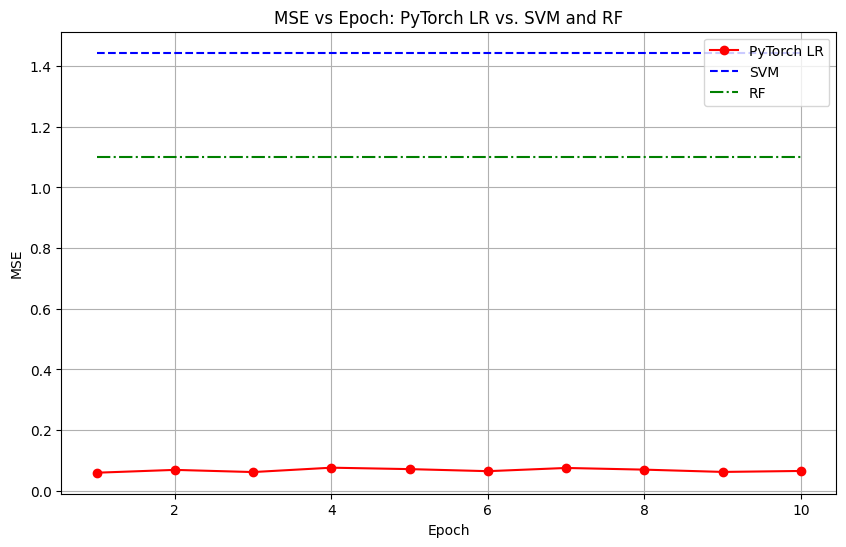

In [36]:
lr_mse_history = train_pytorch_model(epochs=10, batch_size=32, learning_rate=0.01)
svm_mse_value, rf_mse_value = train_sklearn_models()
plot_errors(lr_mse_history, svm_mse_value, rf_mse_value)
